# Sentinal2Geomedian

**what does this notebook do?** this notebook builds on the **GettingStartedWithSentinel2** notebook; it ueses a loop to load data from sentinal 2 A and B over a set period of time, for a set area and concatinates them together. The data is then cast to float format and used to calculate the geomedian for the selected time range. visible light bands are then plotted at a tre colour image. 

**Tags**
`Sentinel2`, `products`, `GeoMedian`, `threeBandImage`, `dc.load`, `query`, `beginner`, `plot`, `image`,

In [3]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import datacube_stats

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('title string', fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')
        
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [3]:
#set up peramiters for data loading

sensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-35.21, -35.31),
        'lon': (149.05, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-06-01')
        }
# use s2b_ard_granule 	 for S2B
#data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

In [4]:
data_sent = {}


sensors_used = 0

for i in sensors:
    try:
        this_sensor = s2aws.load(product= i, group_by='solar_day', **query)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        clear_pixelsa = this_sensor.pixel_quality != 2
        clear_pixelsb = this_sensor.pixel_quality != 3
        clear_pixels = clear_pixelsa * clear_pixelsb
        #clear_data = this_sensor.where(clear_pixels)
    
        data_sent[i] = this_sensor
        sensors_used = sensors_used + 1
        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')
        
        #use masked vs UNmasked for geomedian depending on requierments 

s2a_ard_granule done
s2b_ard_granuledose not have any imagry for this time


i = 's2a_ard_granule'

this_sensor = s2aws.load(product= i, group_by='solar_day', **query)
    
        #retreive projection infromation
crs = this_sensor.crs
crswkt = this_sensor.crs.wkt
affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
clear_pixelsa = this_sensor.pixel_quality != 2
clear_pixelsb = this_sensor.pixel_quality != 3
clear_pixels = clear_pixelsa * clear_pixelsb
clear_data = this_sensor.where(clear_pixels)
    
data_sent[i] = clear_data 
sensors_used = sensors_used + 1
print(i+' done')

In [5]:
#look at the data 
data_sent

{'s2a_ard_granule': <xarray.Dataset>
 Dimensions:        (time: 14, x: 1050, y: 1224)
 Coordinates:
   * time           (time) datetime64[ns] 2017-01-05T00:02:12.026000 ...
   * y              (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
   * x              (x) float64 1.543e+06 1.543e+06 1.543e+06 1.543e+06 ...
 Data variables:
     pixel_quality  (time, y, x) uint8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 ...
     contiguity     (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
     aerosol        (time, y, x) int16 628 628 666 666 666 666 666 666 612 ...
     blue           (time, y, x) int16 770 778 787 803 757 769 767 752 587 ...
     green          (time, y, x) int16 1083 1077 1111 1149 1133 1118 1129 ...
     red            (time, y, x) int16 1261 1253 1192 1228 1207 1193 1230 ...
     rededge1       (time, y, x) int16 1861 1861 1757 1757 1886 1886 1862 ...
     rededge2       (time, y, x) int16 2671 2671 2809 2809 2838 2838 2776 ...
     rededge3       (t

In [6]:
#concatinate all of the sentinal data together into one xarray, ordered by time, if you have more than one sensor!!


data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine



In [7]:
data_sent.time

<xarray.DataArray 'time' (time: 14)>
array(['2017-01-05T00:02:12.026000000', '2017-01-15T00:02:11.026000000',
       '2017-02-04T00:06:21.026000000', '2017-02-14T00:02:11.026000000',
       '2017-02-24T00:02:11.026000000', '2017-03-06T00:06:21.026000000',
       '2017-03-16T00:02:11.026000000', '2017-03-26T00:06:21.026000000',
       '2017-04-05T00:02:21.026000000', '2017-04-15T00:06:31.026000000',
       '2017-04-25T00:02:21.026000000', '2017-05-05T00:06:31.026000000',
       '2017-05-15T00:02:21.026000000', '2017-05-25T00:06:31.026000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-05T00:02:12.026000 ...
Attributes:
    units:    seconds since 1970-01-01 00:00:00

<IPython.core.display.Javascript object>


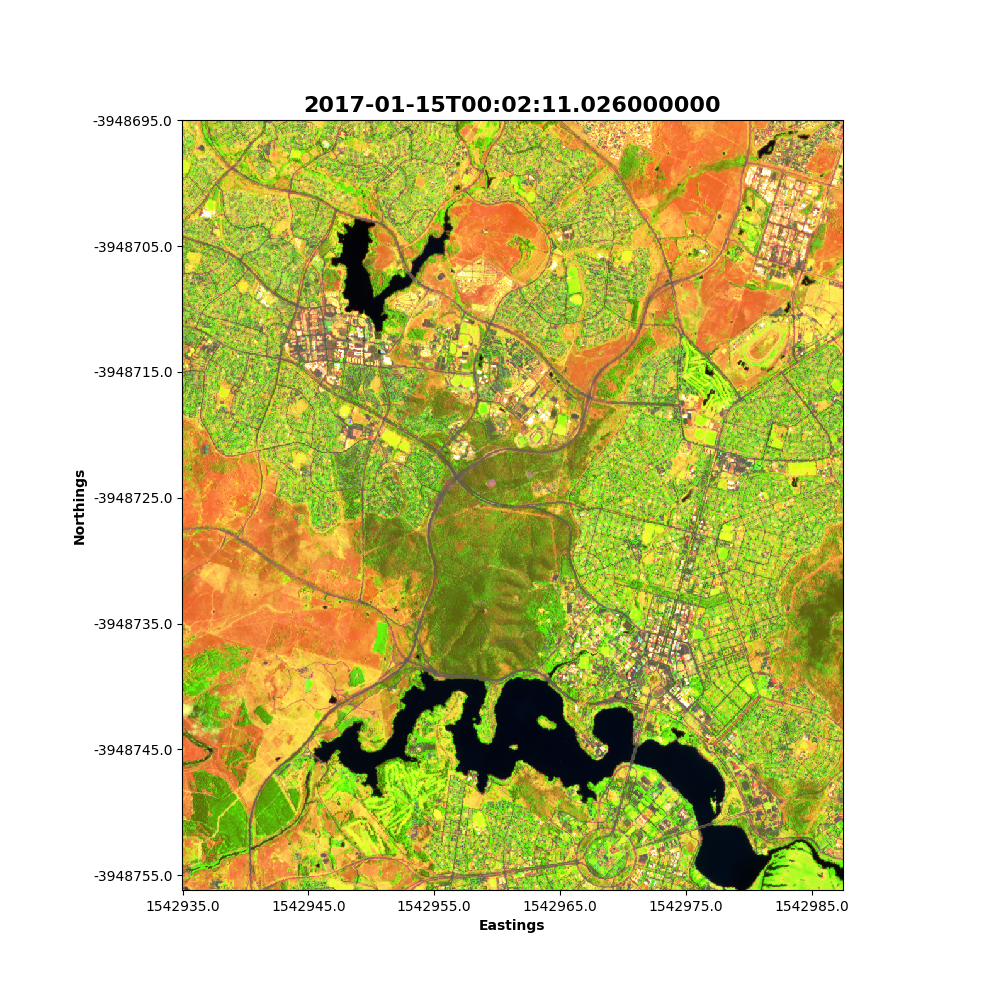

In [26]:
# this is plotting an image from our timeslice, not geomedian

threeBandImage(data_sent, bands = ['swir1', 'nir1', 'blue'], time = 1)

In [9]:
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

In [10]:
#have a look at the data, you can see it's now in float format
data_sent_flt 

<xarray.Dataset>
Dimensions:        (time: 12, x: 1050, y: 1224)
Coordinates:
  * y              (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * time           (time) datetime64[ns] 2016-06-09T00:05:19.242000 ...
  * x              (x) float64 1.543e+06 1.543e+06 1.543e+06 1.543e+06 ...
Data variables:
    pixel_quality  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    contiguity     (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    aerosol        (time, y, x) float64 604.0 604.0 562.0 562.0 562.0 562.0 ...
    blue           (time, y, x) float64 623.0 622.0 568.0 516.0 473.0 500.0 ...
    green          (time, y, x) float64 845.0 855.0 754.0 736.0 700.0 704.0 ...
    red            (time, y, x) float64 972.0 1.036e+03 926.0 912.0 891.0 ...
    rededge1       (time, y, x) float64 1.565e+03 1.565e+03 1.144e+03 ...
    rededge2       (time, y, x) float64 2.378e+03 2.378e+03 1.522e+03 ...
    rededge3       (time, y, x) float64 2.397e+03 2.39

In [11]:
#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)

In [12]:
#have a look at the geomedian data
Sentinal_gm

<xarray.Dataset>
Dimensions:        (x: 1050, y: 1224)
Coordinates:
  * y              (y) float64 -3.949e+06 -3.949e+06 -3.949e+06 -3.949e+06 ...
  * x              (x) float64 1.543e+06 1.543e+06 1.543e+06 1.543e+06 ...
Data variables:
    pixel_quality  (y, x) float64 0.001822 0.002512 0.00901 0.009482 ...
    contiguity     (y, x) float64 254.7 254.5 253.3 253.2 253.4 253.2 252.8 ...
    aerosol        (y, x) float64 -995.6 -994.3 -982.7 -981.8 -983.3 -982.0 ...
    blue           (y, x) float64 -995.5 -994.2 -982.7 -982.1 -983.7 -982.6 ...
    green          (y, x) float64 -995.2 -993.8 -981.6 -981.0 -982.5 -981.2 ...
    red            (y, x) float64 -995.2 -993.6 -980.6 -979.9 -981.6 -980.1 ...
    rededge1       (y, x) float64 -994.5 -992.7 -978.8 -977.8 -979.2 -977.6 ...
    rededge2       (y, x) float64 -993.5 -991.4 -976.0 -974.7 -976.3 -974.5 ...
    rededge3       (y, x) float64 -993.6 -991.5 -976.2 -975.0 -976.6 -974.8 ...
    nir1           (y, x) float64 -993.3 -991.1 -

In [13]:
#Prepare geomedian imagery for plotting

rgb = Sentinal_gm.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


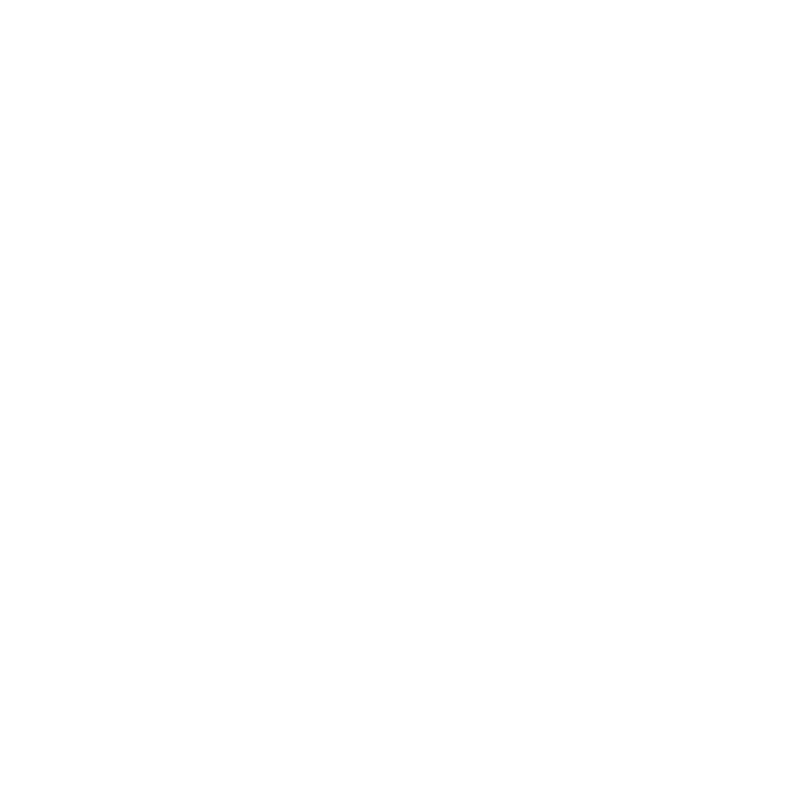

In [14]:
fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [15]:
#end notebook

<IPython.core.display.Javascript object>


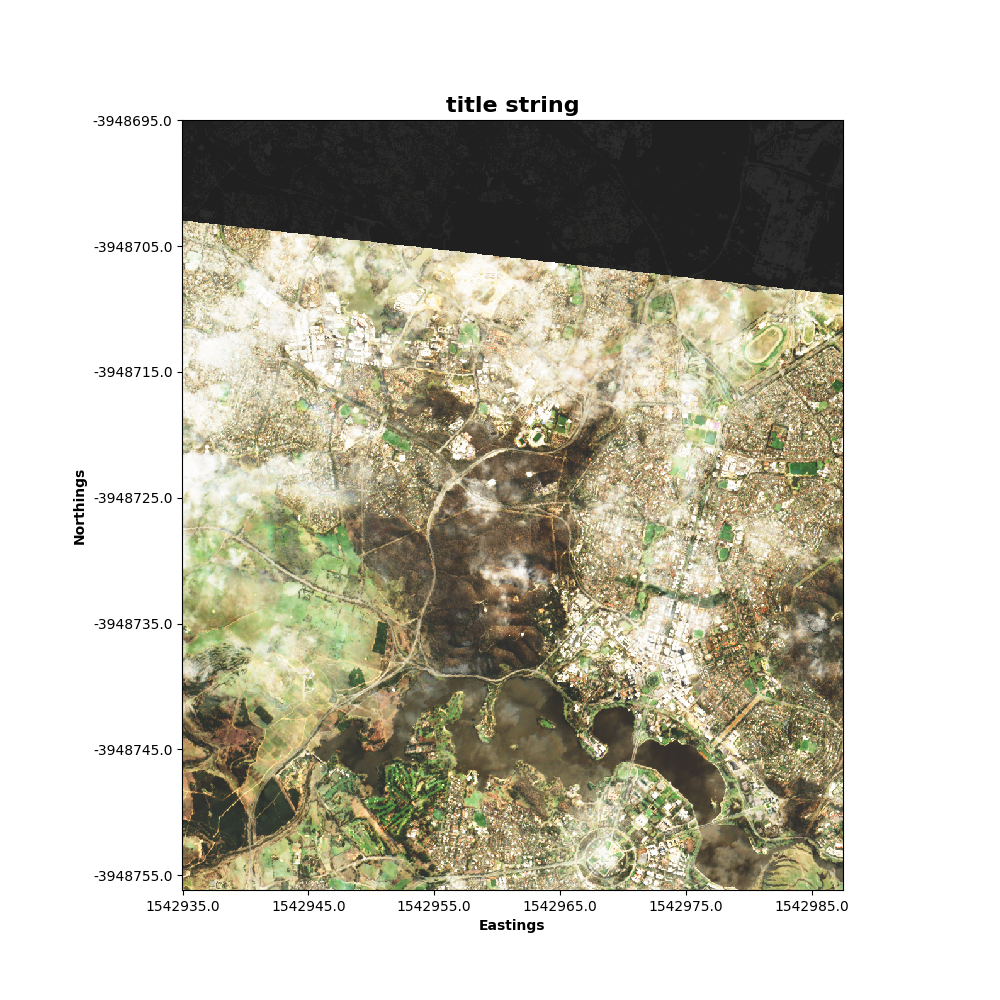

In [16]:
three_band_image_flat(Sentinal_gm, bands = ['red', 'green', 'blue'])